In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.linalg import svd
from scipy import io

In [2]:
# Define the time range
t = np.linspace(0, 5, 100)

# Define the source signals
c = np.array([0.2, 0.4, 0.6, -0.1, -0.3])
d = np.array([0.1, 0.3, -0.2, 0.5, -0.3])
s1 = np.zeros(100)
s2 = np.zeros(100)

for k in range(1, 6):
    s1[(k-1)*20:k*20] = c[k-1] * np.sin(2*np.pi*t[(k-1)*20:k*20])
    s2[(k-1)*20:k*20] = d[k-1] * np.sin(4*np.pi*t[(k-1)*20:k*20])

# Define the mixing matrix
A = np.array([[0.8, -0.6], [0.6, 0.8]])


In [30]:
S = np.array([s1, s2])

In [3]:
# Calculate the observation signals
X = np.dot(A, np.array([s1, s2]))

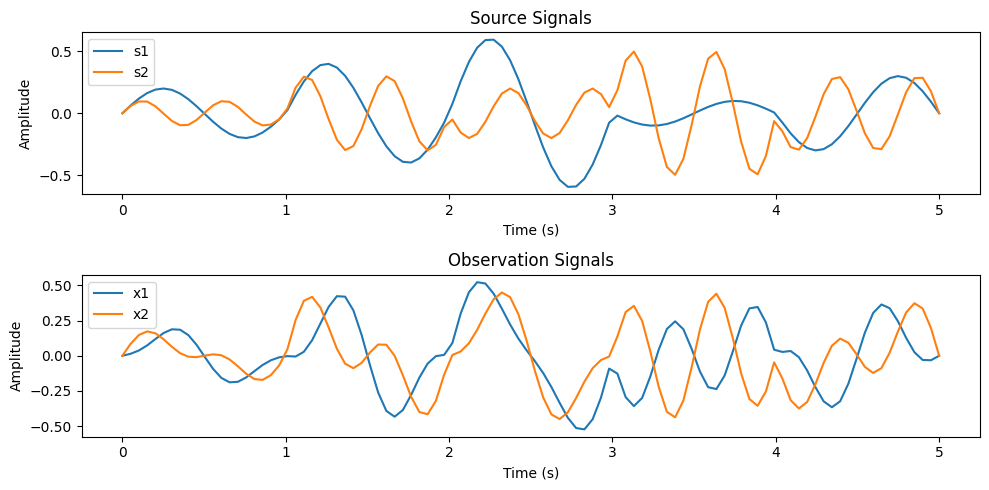

In [4]:
# Plot the source signals and observation signals
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, s1)
plt.plot(t, s2)
plt.title('Source Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['s1', 's2'])

plt.subplot(2, 1, 2)
plt.plot(t, X[0])
plt.plot(t, X[1])
plt.title('Observation Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['x1', 'x2'])

plt.tight_layout()
plt.show()

In [5]:
# Extract the data from the first two windows of X and store them in a 2x200 matrix X_sub
X_sub = X[:, :200]

# Subtract the mean of each column of X_sub to center the data
X_sub = X_sub - np.mean(X_sub, axis=1, keepdims=True)

# Whiten the data to make the columns uncorrelated and have unit variance
cov = np.cov(X_sub)
U, S, Vt = np.linalg.svd(cov)
W = np.dot(np.dot(U, np.diag(1/np.sqrt(S))), U.T)
X_white = np.dot(W, X_sub)

# Apply the FastICA algorithm to the whitened data to estimate the source signals
def fastica(X, max_iter=200, tol=1e-4):
    # Initialize random weights
    W = np.random.rand(X.shape[0], X.shape[0])
    for i in range(X.shape[0]):
        # Deflation scheme: estimate one source at a time
        w = W[i, :].copy()
        for j in range(max_iter):
            # Compute the nonlinearity (here we use a hyperbolic tangent function)
            g = np.tanh(np.dot(w, X))
            # Compute the gradient of the nonlinearity
            g_dot = 1 - g**2
            # Update the weight vector
            w_new = np.dot(X, g.T) / X.shape[1] - np.mean(g_dot) * w
            w_new /= np.linalg.norm(w_new)
            # Check for convergence
            if np.abs(np.abs(np.dot(w_new, w)) - 1) < tol:
                break
            w = w_new
        W[i, :] = w
    # Apply the estimated weights to the data to obtain the estimated sources
    S_est = np.dot(W, X)
    return S_est

S_est = fastica(X_white)

# Reconstruct the estimated source signals by applying the inverse of the whitening matrix to S_est
S_est = np.dot(np.dot(np.linalg.inv(W), A.T), S_est)




In [6]:
# Use fastICA algorithm
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2)
S_est = ica.fit_transform(X.T).T

# Disambiguate and permute the ICA estimates
W = ica.mixing_
A_est = np.dot(np.linalg.pinv(W), A)
d = np.diag(np.sign(np.diag(A_est)))
A_est = np.dot(A_est, d)
W = np.dot(d, W)
S_est = np.dot(np.dot(np.linalg.inv(W), A.T), X)

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


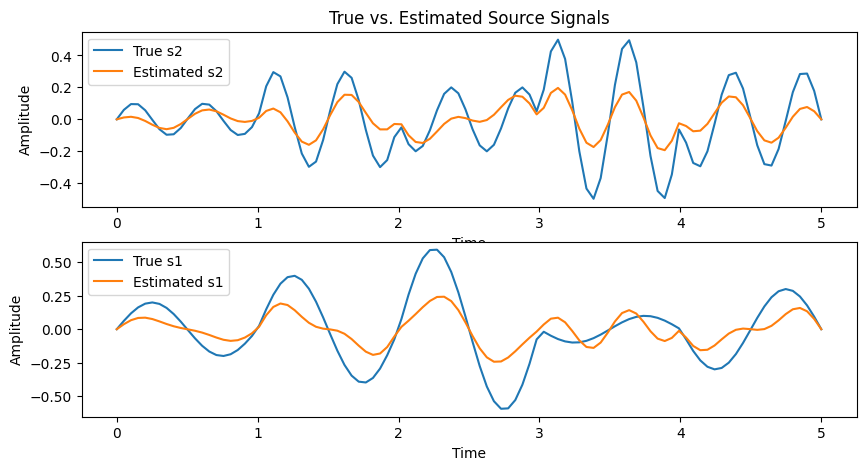

In [7]:
# Plot the estimated source signals and compare them to the true source signals
plt.figure(figsize=(10,5))

# Plot estimated and true s2
plt.subplot(2,1,1)
plt.plot(t, s2, label='True s2')
plt.plot(t, S_est[1], label='Estimated s2')
plt.legend()
plt.title('True vs. Estimated Source Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot estimated and true s1
plt.subplot(2,1,2)
plt.plot(t, s1, label='True s1')
plt.plot(t, S_est[0], label='Estimated s1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

In [18]:
S1_est_norm = (S_est[0] / np.max(np.abs(S_est[0])))
S2_est_norm = (S_est[1] / np.max(np.abs(S_est[1])))
s2_norm = s2 / np.max(np.abs(s2))
s1_norm = s1 / np.max(np.abs(s1))


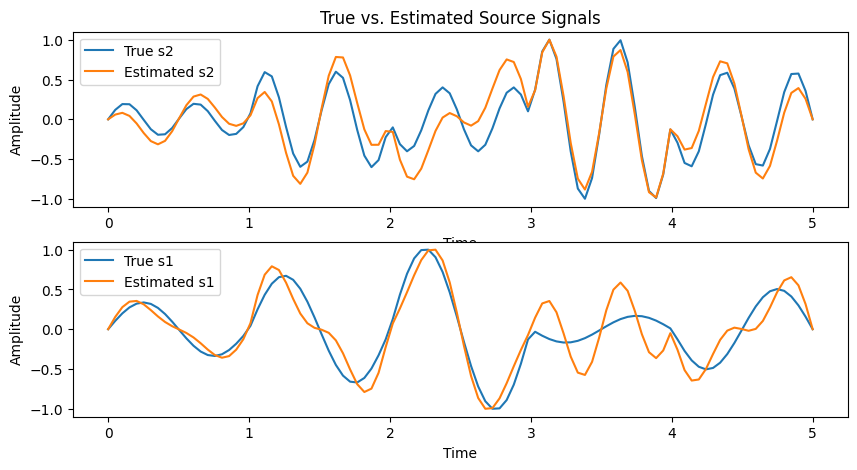

In [19]:
plt.figure(figsize=(10,5))

# Plot estimated and true s2
plt.subplot(2,1,1)
plt.plot(t, s2_norm, label='True s2')
plt.plot(t, S2_est_norm, label='Estimated s2')
plt.legend()
plt.title('True vs. Estimated Source Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot estimated and true s1
plt.subplot(2,1,2)
plt.plot(t,s1_norm , label='True s1')
plt.plot(t, S1_est_norm  , label='Estimated s1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

In [20]:
error_s1 = np.linalg.norm(S1_est_norm - s1_norm ) / np.linalg.norm(s1_norm)
error_s2 = np.linalg.norm(S2_est_norm - s2_norm) / np.linalg.norm(s2_norm)


In [21]:
print("error S1 : " , error_s1)
print("error S2 : " , error_s2)

error S1 :  0.4821977042625335
error S2 :  0.48832101851281035


In [22]:
# use all X
X_sub = X

# Subtract the mean of each column of X_sub to center the data
X_sub = X_sub - np.mean(X_sub, axis=1, keepdims=True)

# Whiten the data to make the columns uncorrelated and have unit variance
cov = np.cov(X_sub)
U, S, Vt = np.linalg.svd(cov)
W = np.dot(np.dot(U, np.diag(1/np.sqrt(S))), U.T)
X_white = np.dot(W, X_sub)

# Apply the FastICA algorithm to the whitened data to estimate the source signals
def fastica(X, max_iter=200, tol=1e-4):
    # Initialize random weights
    W = np.random.rand(X.shape[0], X.shape[0])
    for i in range(X.shape[0]):
        # Deflation scheme: estimate one source at a time
        w = W[i, :].copy()
        for j in range(max_iter):
            # Compute the nonlinearity (here we use a hyperbolic tangent function)
            g = np.tanh(np.dot(w, X))
            # Compute the gradient of the nonlinearity
            g_dot = 1 - g**2
            # Update the weight vector
            w_new = np.dot(X, g.T) / X.shape[1] - np.mean(g_dot) * w
            w_new /= np.linalg.norm(w_new)
            # Check for convergence
            if np.abs(np.abs(np.dot(w_new, w)) - 1) < tol:
                break
            w = w_new
        W[i, :] = w
    # Apply the estimated weights to the data to obtain the estimated sources
    S_est = np.dot(W, X)
    return S_est

S_est = fastica(X_white)

# Reconstruct the estimated source signals by applying the inverse of the whitening matrix to S_est
S_est = np.dot(np.dot(np.linalg.inv(W), A.T), S_est)


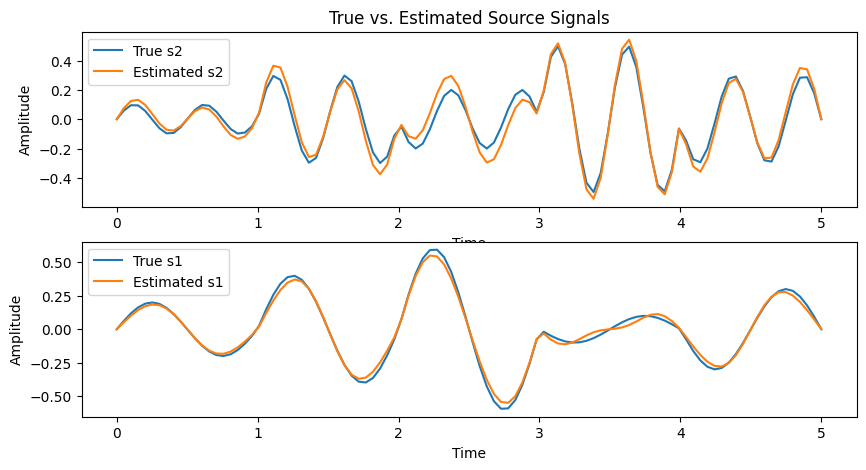

In [23]:
# Plot the estimated source signals and compare them to the true source signals
plt.figure(figsize=(10,5))

# Plot estimated and true s2
plt.subplot(2,1,1)
plt.plot(t, s2, label='True s2')
plt.plot(t, S_est[1], label='Estimated s2')
plt.legend()
plt.title('True vs. Estimated Source Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot estimated and true s1
plt.subplot(2,1,2)
plt.plot(t, s1, label='True s1')
plt.plot(t, S_est[0], label='Estimated s1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

In [31]:
error_s2 = np.linalg.norm(S_est - S) / np.linalg.norm(S)
print("error using all X : " , error_s2)

error using all X :  0.17175163773945898


In [36]:
# add noise 


# Generate the noise matrix W
W = np.random.normal(0, 1, (2, 100))
W /= np.linalg.norm(W)

# Choose the SNR value and compute the standard deviation of the noise
SNR_dB = 20
sigma = np.sqrt(1 / 10**(SNR_dB / 10))

# Add the noise to the data matrix
Y = X + sigma * W

# use all X
X_sub = Y

# Subtract the mean of each column of X_sub to center the data
X_sub = X_sub - np.mean(X_sub, axis=1, keepdims=True)

# Whiten the data to make the columns uncorrelated and have unit variance
cov = np.cov(X_sub)
U, S, Vt = np.linalg.svd(cov)
W = np.dot(np.dot(U, np.diag(1/np.sqrt(S))), U.T)
X_white = np.dot(W, X_sub)

S_est = fastica(X_white)

# Reconstruct the estimated source signals by applying the inverse of the whitening matrix to S_est
S_est = np.dot(np.dot(np.linalg.inv(W), A.T), S_est)



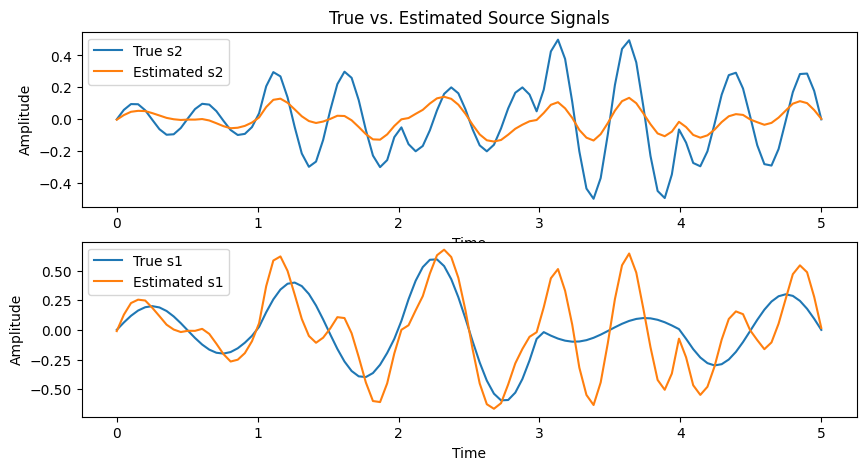

In [37]:
# Plot the estimated source signals and compare them to the true source signals
plt.figure(figsize=(10,5))

# Plot estimated and true s2
plt.subplot(2,1,1)
plt.plot(t, s2, label='True s2')
plt.plot(t, S_est[1], label='Estimated s2')
plt.legend()
plt.title('True vs. Estimated Source Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot estimated and true s1
plt.subplot(2,1,2)
plt.plot(t, s1, label='True s1')
plt.plot(t, S_est[0], label='Estimated s1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.9/dist-pack

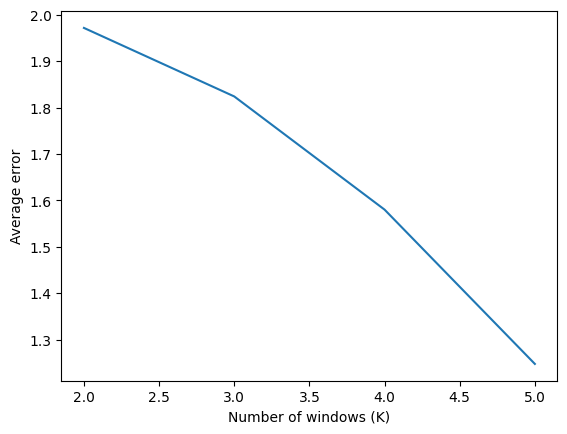

In [40]:

# Add noise
SNR = 10**(20/10) # Signal-to-noise ratio in dB
sigma = np.sqrt(np.sum(X**2) / (2 * X.shape[1] * SNR))
W = np.random.normal(0, 1, size=(2, 2))
W /= np.linalg.norm(W, axis=0)
Y = X + sigma * np.dot(W, np.random.normal(0, 1, size=(2, 100)))

# Define a function to estimate sources and calculate error
def bss_error(Y, K):
    N = Y.shape[1]
    M = Y.shape[0]
    L = N // K # Length of each window
    
    error = 0
    for k in range(K):
        X_k = Y[:, k*L:(k+1)*L]
        
        # Apply ICA to estimate sources
        ica = FastICA(n_components=M, whiten=True)
        S_est = ica.fit_transform(X_k.T).T
        
        # Calculate error between true and estimated sources
        S = X[:, k*L:(k+1)*L]
        S_norm = S / np.linalg.norm(S, axis=1, keepdims=True)
        S_est_norm = S_est / np.linalg.norm(S_est, axis=1, keepdims=True)
        error += np.linalg.norm(S_norm - S_est_norm, ord='fro') / np.linalg.norm(S_norm, ord='fro')
    
    return error / K

# Calculate error for different window sizes
K_values = [2, 3, 4, 5]
errors = []
for K in K_values:
    error = bss_error(Y, K)
    errors.append(error)

# Plot the results
plt.plot(K_values, errors)
plt.xlabel('Number of windows (K)')
plt.ylabel('Average error')
plt.show()


In [43]:
errors

[1.9717610067863451,
 1.8240440230531572,
 1.5800902460673165,
 1.2474686596393743]

**Section 2**

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


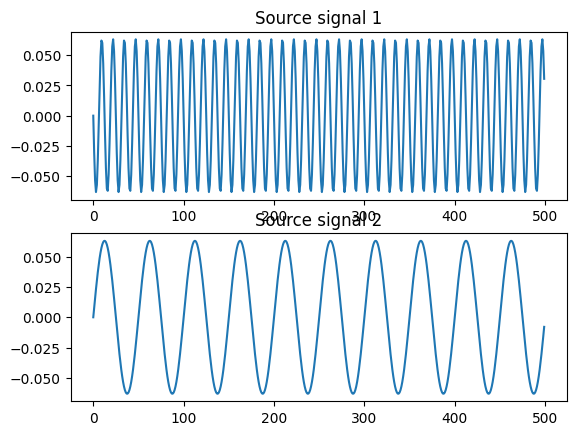

In [1]:
# Load the observation matrix X1 from the X1.mat file
mat = io.loadmat('X1.mat')
X1 = mat['X1']

# Apply FastICA to estimate the source signals
ica = FastICA(n_components=2)
S = ica.fit_transform(X1.T)

# Plot the estimated source signals
t = np.arange(X1.shape[1])
fig, axs = plt.subplots(2)
axs[0].plot(t, S[:, 0])
axs[0].set_title('Source signal 1')
axs[1].plot(t, S[:, 1])
axs[1].set_title('Source signal 2')
plt.show()

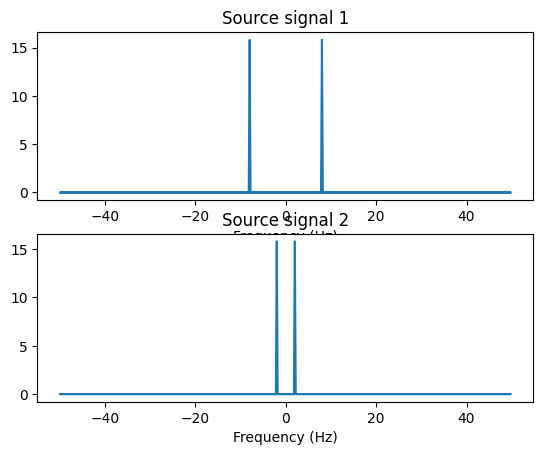

In [3]:

# Compute the Fourier transform of the estimated source signals
S_fft = np.fft.fft(S, axis=0)

# Compute the corresponding frequency axis
fs = 100  # Sampling frequency in Hz
N = S.shape[0]
f = np.fft.fftfreq(N, d=1/fs)

# Plot the Fourier transform of the estimated source signals
fig, axs = plt.subplots(2)
axs[0].plot(f, np.abs(S_fft[:, 0]))
axs[0].set_title('Source signal 1')
axs[0].set_xlabel('Frequency (Hz)')
axs[1].plot(f, np.abs(S_fft[:, 1]))
axs[1].set_title('Source signal 2')
axs[1].set_xlabel('Frequency (Hz)')
plt.show()


/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


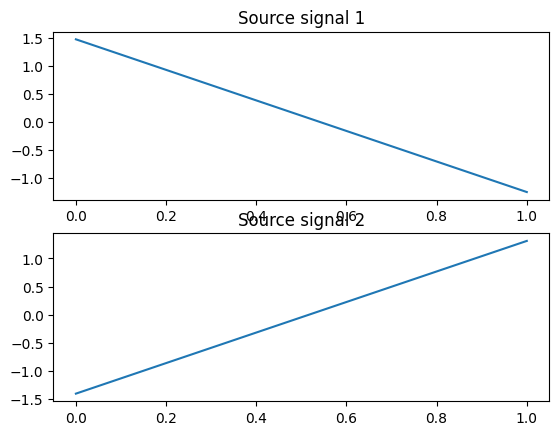

In [15]:
# Load the observation matrix X2 from X2.mat
X2 = io.loadmat('X2.mat')['X2']

# Perform ICA on X2
ica = FastICA(n_components=2)
S_hat = ica.fit_transform(X2)

# Plot the estimated source signals
t = np.arange(S_hat.shape[0])
fig, axs = plt.subplots(2)
axs[0].plot(t, S_hat[:, 0])
axs[0].set_title('Source signal 1')
axs[1].plot(t, S_hat[:, 1])
axs[1].set_title('Source signal 2')
plt.show()

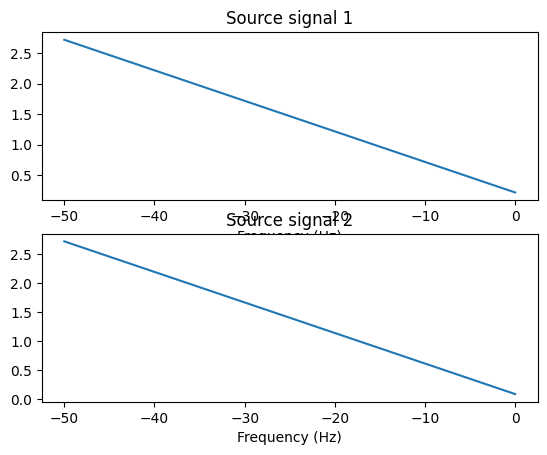

In [16]:
# Compute the Fourier transform of the estimated source signals
S_fft = np.fft.fft(S_hat, axis=0)

# Compute the corresponding frequency axis
fs = 100  # Sampling frequency in Hz
N = S_hat.shape[0]
f = np.fft.fftfreq(N, d=1/fs)

# Plot the Fourier transform of the estimated source signals
fig, axs = plt.subplots(2)
axs[0].plot(f, np.abs(S_fft[:, 0]))
axs[0].set_title('Source signal 1')
axs[0].set_xlabel('Frequency (Hz)')
axs[1].plot(f, np.abs(S_fft[:, 1]))
axs[1].set_title('Source signal 2')
axs[1].set_xlabel('Frequency (Hz)')
plt.show()